In [1]:
from typing import Tuple, Optional, List, Callable

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import stats
from frame_whitening import types

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


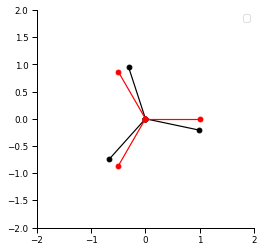

In [3]:
from functools import partial

def _get_dg_pow_asymmetric_feedforward(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    y: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    alpha: float = 0.0,
    beta: float = 0.0,
) -> npt.NDArray[np.float64]:
    """Compute gradient of objective wrt g when f(g) = g^{alpha+1}.
    With asymmetry on feedforward weights.
    """
    w0 = np.sum(W**2, axis=0)
    z = W.T @ np.linalg.inv(A) @ y
    dv = (z**2).mean(axis=-1) - w0
    dg = -(alpha + 1) * (g**alpha) * dv + beta * np.sign(g ** (1 + alpha))
    return dg

def _get_dg_pow_asymmetric_feedback(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    y: npt.NDArray[np.float64],
    alpha: float = 0.0,
    beta: float = 0.0,
) -> npt.NDArray[np.float64]:
    """Compute gradient of objective wrt g when f(g) = g^{alpha+1}. 
    With asymmetric feedback weights.
    """
    w0 = np.sum(W**2, axis=0)
    z = W.T @ y
    dv = (z**2).mean(axis=-1) - w0
    dg = -(alpha + 1) * (g**alpha) * dv + beta * np.sign(g ** (1 + alpha))
    return dg

def _get_y_pow_asymmetric_feedforward(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    x: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    alpha: float = 0,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Compute steady-state y for a given x and g and alpha.
    With asymmetric feeforward weights.
    f(g) = g^{alpha+1}
    """
    G = np.diag(g ** (alpha + 1))
    y = A @ np.linalg.inv(W @ G @ W.T) @ x
    return y, G

def _get_y_pow_asymmetric_feedback(
    g: npt.NDArray[np.float64],
    W: npt.NDArray[np.float64],
    x: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    alpha: float = 0,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Compute steady-state y for a given x and g and alpha.
    With asymmetric feedback weights.
    f(g) = g^{alpha+1}
    """
    G = np.diag(g ** (alpha + 1))
    y =  np.linalg.inv(W @ G @ W.T) @ A @ x
    return y, G

In [58]:
def simulate(
    cholesky_list: List[npt.NDArray[np.float64]],
    W: npt.NDArray[np.float64],
    A: npt.NDArray[np.float64],
    forward: bool,
    batch_size: int = 64,
    n_batch: int = 1024,
    lr_g: float = 5e-3,
    g0: Optional[npt.NDArray[np.float64]] = None,
    seed: Optional[float] = None,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    if seed is not None:
        np.random.seed(seed)

    # initialize random set of gains g
    N, K = W.shape
    g = g0 if g0 is not None else np.ones(K)

    g_all = []
    g_last = []
    errors = []

    if forward:
        get_y = partial(_get_y_pow_asymmetric_feedforward, A=A, alpha=alpha)
        get_dg = partial(_get_dg_pow_asymmetric_feedforward, A=A, alpha=alpha)
    else:
        get_y = partial(_get_y_pow_asymmetric_feedback, A=A, alpha=alpha)
        get_dg = partial(_get_dg_pow_asymmetric_feedback, alpha=alpha)

    # run simulation with minibatches
    Ixx = np.eye(N)
    for Lxx in cholesky_list:
        Cxx = Lxx @ Lxx.T
        for _ in range(n_batch):
            x = stats.sample_x(Lxx, batch_size)  # draw a sample of x

            y, G = get_y(g, W, x)
            M = np.linalg.inv(W @ G @ W.T)
            M = A @ M if forward else M @ A

            error = np.trace(np.abs(M @ Cxx @ M.T - Ixx)) / N
            errors.append(error)

            dg = get_dg(g, W, y)
            g = g - lr_g * dg  # gradient descent
            z = W.T @ y
            g_all.append(g)
        g_last.append(g)

    g_last = np.stack(g_last, 0)
    g_all = np.stack(g_all, 0)
    return g_last, g_all, errors  # type: ignore

alpha = 1.
g0 = fw.simulation.init_g_const(0.1, 3, types.FuncType.POWER, alpha=alpha)

seed = 42069
np.random.seed(seed)
batch_size = 256
n_batch = 5000
lr_g = 5e-3
orthogonal = True

Q = fw.rot2(np.deg2rad(35))
kappa = 8
Cxx0 = Q @ np.diag([kappa, 1]) @ Q.T * 1 / (np.sqrt(kappa))

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
W = fw.get_mercedes_frame()
N, K = W.shape

if orthogonal:
    A, _ = np.linalg.qr(np.random.randn(2, 2))
else:
    A = np.random.randn(2, 2)
    A /= np.linalg.norm(A, ord=2)

forward = True
g_last, g_all, errors = simulate(
    cholesky_list,
    W,
    A,
    forward,
    batch_size,
    n_batch,
    lr_g,
    g0=g0,
    seed=seed,
)

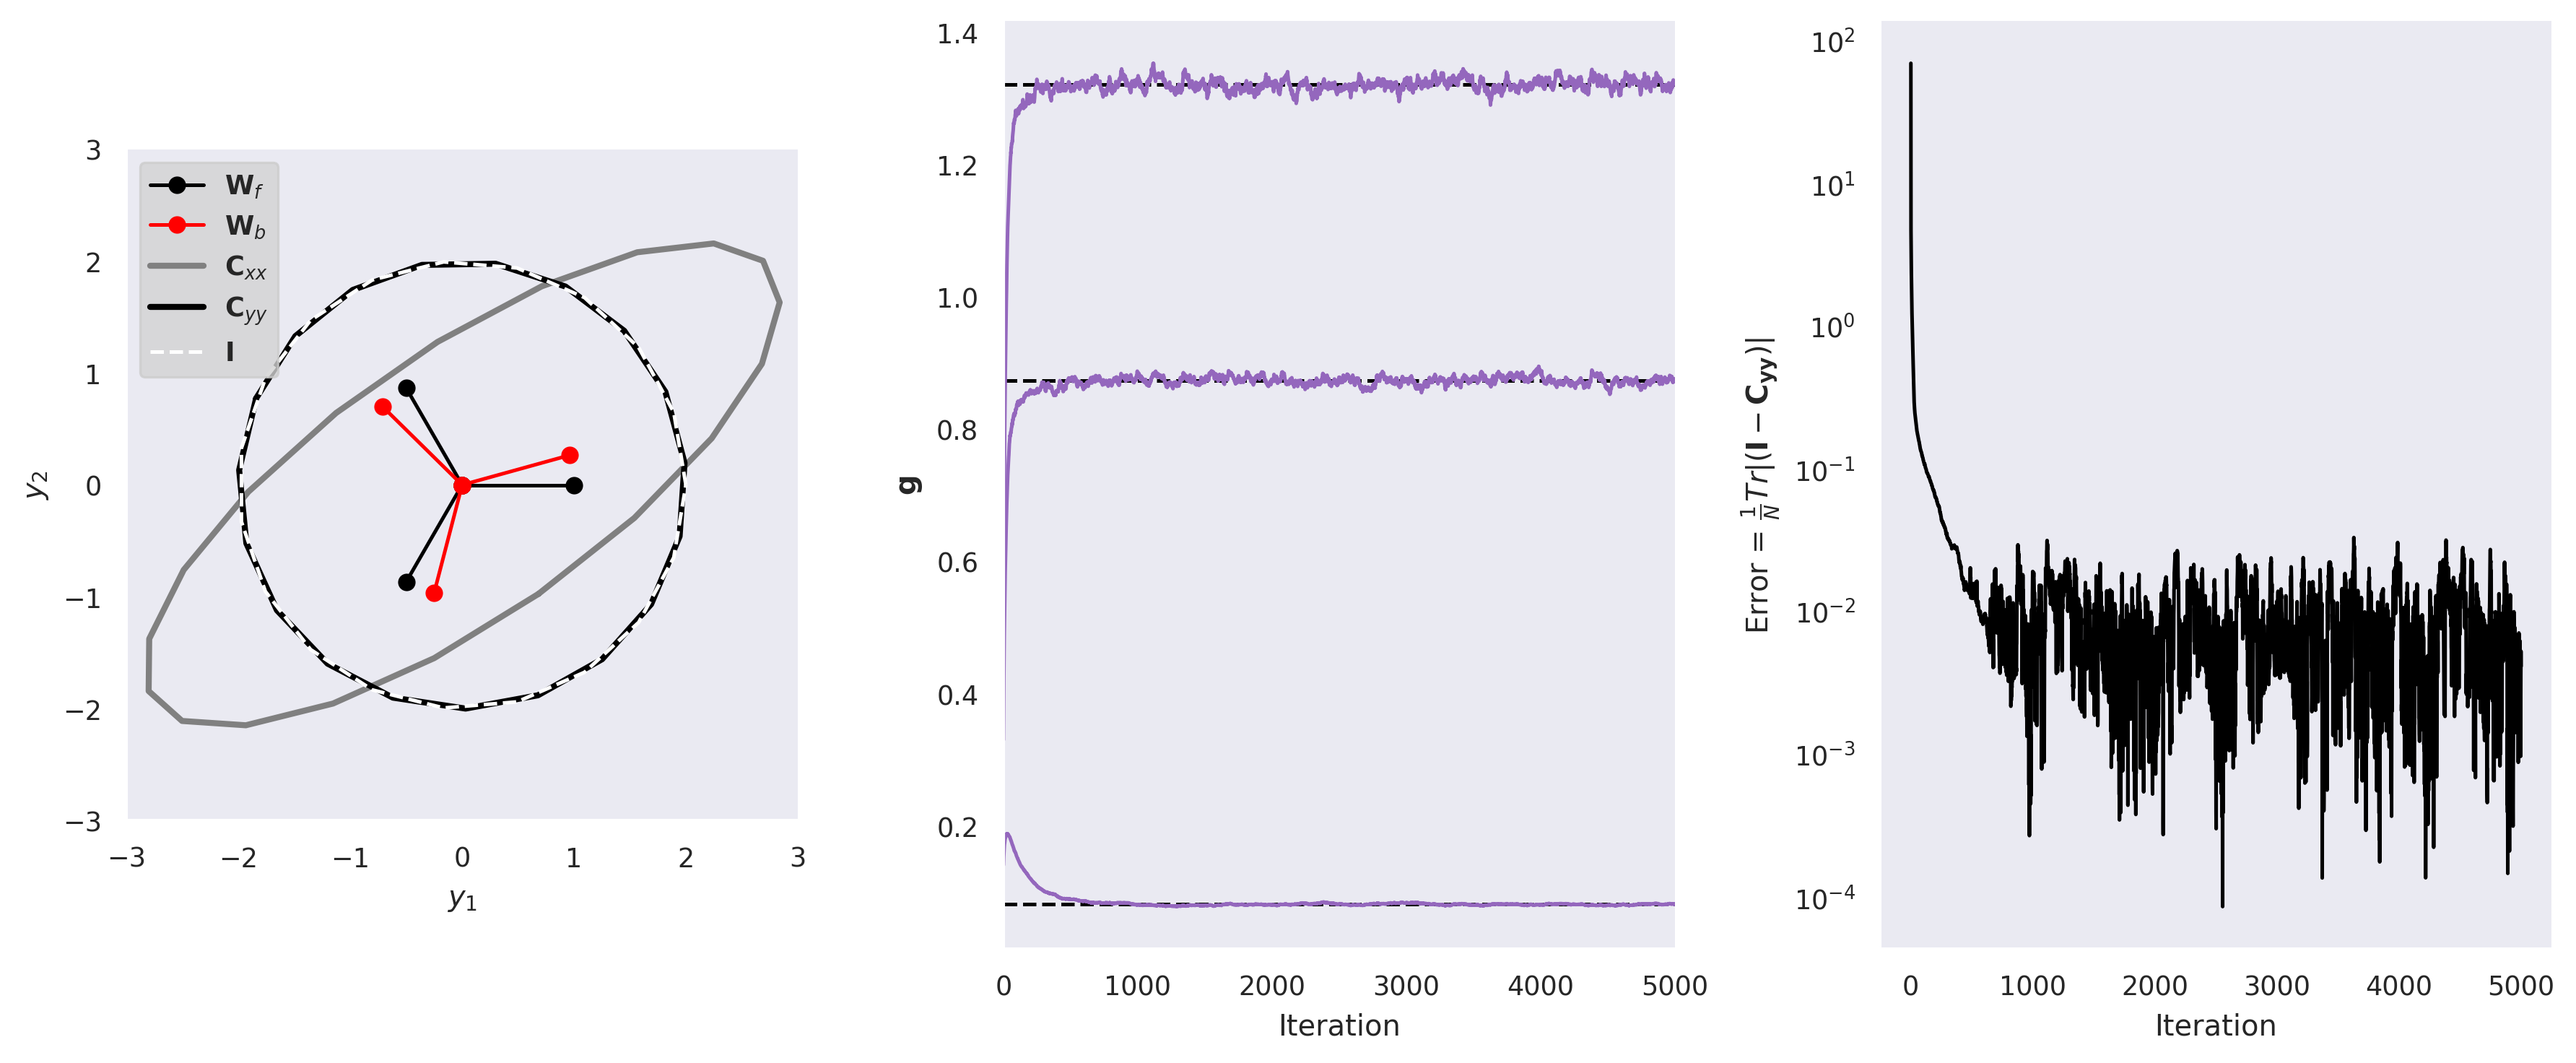

In [57]:
Cxx = Cxx0 if forward else A @ Cxx0 @ A.T
g_opt = fw.compute_g_opt(sp.linalg.fractional_matrix_power(Cxx, .5), W)
with sns.plotting_context("paper"), sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=300)

    Wb, Wf = (W, A@W) if forward else (A@W, W)
    fwplt.plot_frame2d(Wf, ax=ax[0], color='k', label=r"${\bf W}_f$")
    fwplt.plot_frame2d(Wb, ax=ax[0], color='r', label=r"${\bf W}_b$")
    fwplt.plot_ellipse(Cxx0, ax=ax[0], color='grey', linewidth=2, label=r"${\bf C}_{xx}$")
    M =  np.linalg.inv(W @ np.power(np.diag(g_last[0]), 1+alpha) @ W.T)
    M = A @ M if forward else M @ A

    fwplt.plot_ellipse(M @ Cxx0 @ M.T, ax=ax[0], color='k', linewidth=2, label=r"${\bf C}_{yy}$")
    fwplt.plot_ellipse(np.eye(2), ax=ax[0], linestyle="--", color='w', label=r"${\bf I}$")
    ax[0].axis("square")
    lim = 3
    ax[0].set(xlim=(-lim, lim), ylim=(-lim, lim), xlabel=r"$y_1$", ylabel=r"$y_2$")
    ax[0].legend(facecolor='lightgrey')

    ax[1].hlines(g_opt, 0, n_batch, color="k", linestyle="--")
    ax[1].plot(np.power(g_all, 1+alpha), color='C4')
    ax[1].set(xlim=(0, n_batch), ylabel=r"${\bf g}$", xlabel="Iteration")

    ax[2].plot(errors, 'k')
    ax[2].set(yscale="log", ylabel=r"Error = $\frac{1}{N} Tr\vert({\bf I} - {\bf C_{yy}})\vert$",xlabel="Iteration")

    sns.despine()
    fig.tight_layout()